# Noah Santschi-Cooney 116361061

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

In [51]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, SGDClassifier, LogisticRegression
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import ShuffleSplit, cross_val_score, StratifiedShuffleSplit, train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_absolute_error
from sklearn.cross_decomposition import CCA

In [9]:
df = pd.read_csv("datasets/reviews.csv.gz", compression="gzip")

In [10]:
print(df.shape)
print(df.dtypes)
df.describe(include='all')

(48136, 15)
age               float64
body type          object
bust size          object
category           object
fit                object
height             object
item_id             int64
rating            float64
rented for         object
review_date        object
review_summary     object
review_text        object
size                int64
user_id             int64
weight             object
dtype: object


,age,body type,bust size,category,fit,height,item_id,rating,rented for,review_date,review_summary,review_text,size,user_id,weight
count,47894.000000,44544,43567,48136,48136,47952,4.813600e+04,48116.000000,48133,48136,48136,48136,48136.000000,48136.000000,40594
unique,NaN,7,95,62,3,24,NaN,NaN,8,2120,41417,47935,NaN,NaN,173
top,NaN,hourglass,34b,dress,fit,"5' 4""",NaN,NaN,wedding,"June 15, 2016",b'Stylist Review',b'.',NaN,NaN,130lbs
freq,NaN,13887,6732,23179,35430,7100,NaN,NaN,14411,208,230,18,NaN,NaN,3576
mean,33.866580,NaN,NaN,NaN,NaN,NaN,1.043875e+06,9.084255,NaN,NaN,NaN,NaN,12.248255,499091.944470,NaN
std,8.018446,NaN,NaN,NaN,NaN,NaN,8.067556e+05,1.436092,NaN,NaN,NaN,NaN,8.523070,288853.095706,NaN
min,0.000000,NaN,NaN,NaN,NaN,NaN,1.233730e+05,2.000000,NaN,NaN,NaN,NaN,0.000000,47.000000,NaN
25%,29.000000,NaN,NaN,NaN,NaN,NaN,1.941820e+05,8.000000,NaN,NaN,NaN,NaN,8.000000,249516.000000,NaN
50%,32.000000,NaN,NaN,NaN,NaN,NaN,9.458800e+05,10.000000,NaN,NaN,NaN,NaN,12.000000,498811.000000,NaN
75%,37.000000,NaN,NaN,NaN,NaN,NaN,1.678888e+06,10.000000,NaN,NaN,NaN,NaN,16.000000,749178.750000,NaN


# Finding NaNs and other bad data

In [11]:
print(df['body type'].unique())
print(df['fit'].unique())
print(df['rented for'].unique())

['athletic' 'full bust' nan 'petite' 'hourglass' 'straight & narrow'
 'pear' 'apple']
['fit' 'large' 'small']
['everyday' 'wedding' 'work' 'other' 'formal affair' 'party' 'date'
 'vacation' nan]


In [12]:
# We see that there are nans in some columns, so lets count how many in what columns
for column in df.columns:
    print(f"{column} nans: {df[column].isna().sum()}")

age nans: 242
body type nans: 3592
bust size nans: 4569
category nans: 0
fit nans: 0
height nans: 184
item_id nans: 0
rating nans: 20
rented for nans: 3
review_date nans: 0
review_summary nans: 0
review_text nans: 0
size nans: 0
user_id nans: 0
weight nans: 7542


Quite a number of NaNs in this dataset. For a first pass, we will work with a dataset that has any rows with a NaN simply dropped. We can work with alternative methods later on

In [13]:
df_no_nan = df
for column in df.columns:
    df_no_nan = (df_no_nan[~(df_no_nan[column].isna())]).copy()
    df_no_nan.reset_index(drop=True, inplace=True)
f"{(df_no_nan.shape[0]/df.shape[0])*100}% of original dataset remaining"

'76.19453215888316% of original dataset remaining'

# Age distribution in log-scale
We can see that there are a number of rows where the age < 18 and > 100.
On further inspection of ages below 18, we see a number of ages reported as < 10 and the same can be seeing for > 100.
We can see later how much of an effect this has on the model

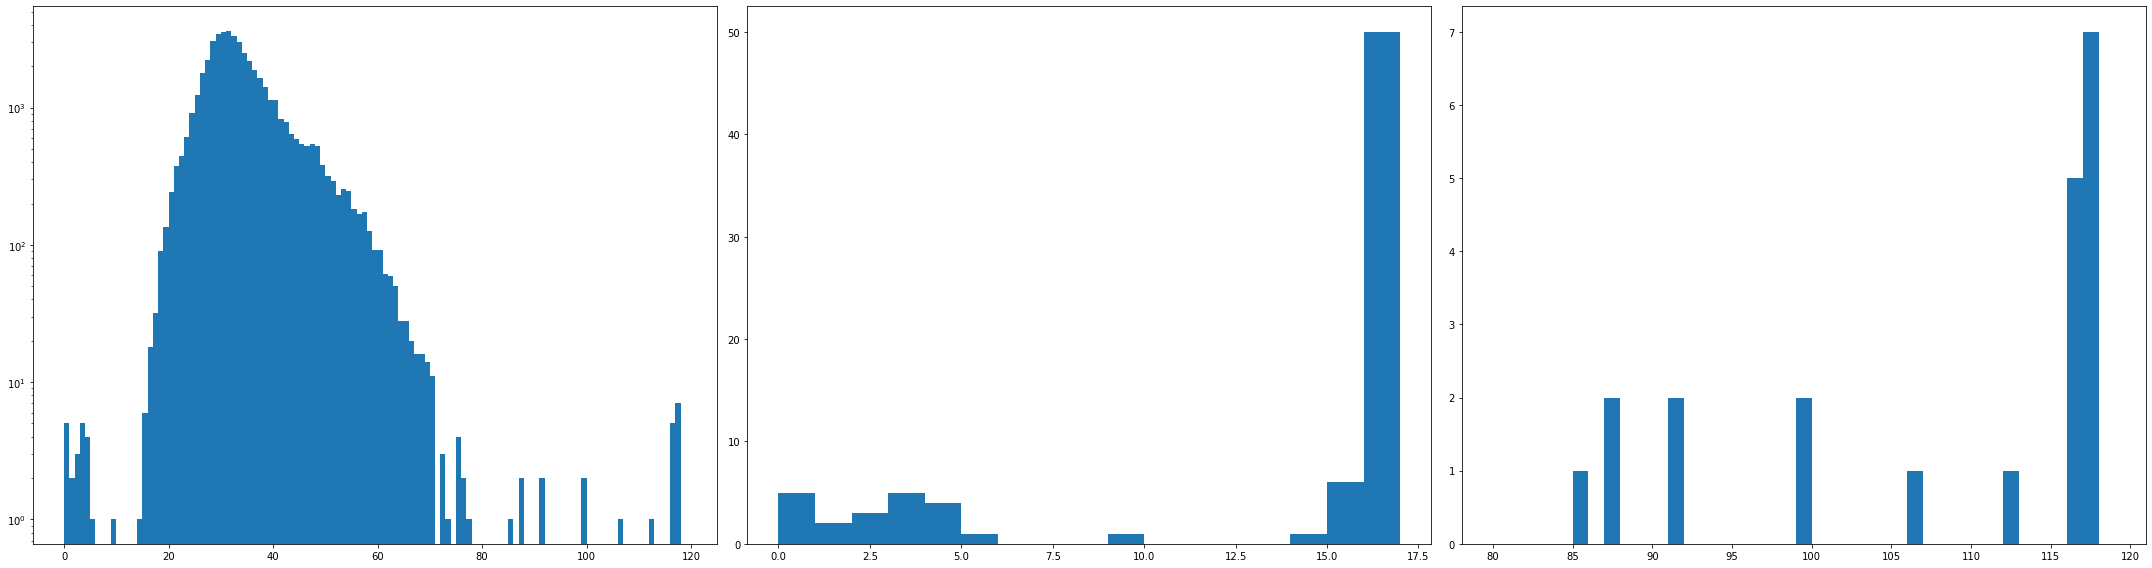

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 8))
ax[0].hist(df['age'], bins=[x for x in range(0, 120, 1)], log=True)
ax[1].hist(df['age'], bins=[x for x in range(0, 18, 1)])
ax[2].hist(df['age'], bins=[x for x in range(80, 120, 1)])
fig.tight_layout()

For purpose of this analysis, we will consider ages above 100 and below 10 to be invalid

In [15]:
df_no_nan = (df_no_nan[~(df_no_nan['age'] < 10)]).copy()
df_no_nan.reset_index(drop=True, inplace=True)
df_no_nan = (df_no_nan[~(df_no_nan['age'] > 100)])
df_no_nan.reset_index(drop=True, inplace=True)

In [16]:
df_no_nan.describe(include='all')

,age,body type,bust size,category,fit,height,item_id,rating,rented for,review_date,review_summary,review_text,size,user_id,weight
count,36658.000000,36658,36658,36658,36658,36658,3.665800e+04,36658.000000,36658,36658,36658,36658,36658.000000,36658.000000,36658
unique,NaN,7,88,61,3,24,NaN,NaN,8,2066,32021,36531,NaN,NaN,169
top,NaN,hourglass,34b,dress,fit,"5' 4""",NaN,NaN,wedding,"June 15, 2016",b'Stylist Review',b'.',NaN,NaN,130lbs
freq,NaN,11045,5872,17618,26914,5508,NaN,NaN,10569,153,132,16,NaN,NaN,3234
mean,34.079792,NaN,NaN,NaN,NaN,NaN,1.050562e+06,9.077909,NaN,NaN,NaN,NaN,11.468602,498541.831742,NaN
std,7.930798,NaN,NaN,NaN,NaN,NaN,8.109679e+05,1.442267,NaN,NaN,NaN,NaN,7.855139,289356.593583,NaN
min,14.000000,NaN,NaN,NaN,NaN,NaN,1.233730e+05,2.000000,NaN,NaN,NaN,NaN,0.000000,47.000000,NaN
25%,29.000000,NaN,NaN,NaN,NaN,NaN,1.942320e+05,8.000000,NaN,NaN,NaN,NaN,4.000000,249028.000000,NaN
50%,32.000000,NaN,NaN,NaN,NaN,NaN,9.543030e+05,10.000000,NaN,NaN,NaN,NaN,9.000000,498036.500000,NaN
75%,38.000000,NaN,NaN,NaN,NaN,NaN,1.687082e+06,10.000000,NaN,NaN,NaN,NaN,16.000000,748908.000000,NaN


# Data Conversions

Having weight and height in numeric format could be useful given they have a natural order, so we will convert 'height' from format `<feet>' <inches>"` to inches and weight from the format `<weight>lbs` to pounds

In [32]:
bust_to_num = {
    'aa': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'd+': 5, 'dd': 6, 'ddd/e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12,
}
for cup in bust_to_num:
    bust_to_num[cup] = bust_to_num[cup] * 9

df_no_nan['height_in'] = df_no_nan['height'].apply(lambda x: (int(x.split(' ')[0][:-1])*12) + (int(x.split(' ')[1][:-1]))).astype('int64')
df_no_nan['weight_lbs'] = df_no_nan['weight'].apply(lambda x: int(x[:-3])).astype('int64')
df_no_nan['bust_size_num'] = df_no_nan['bust size'].apply(lambda i: bust_to_num[i[2:]]+(int(i[:2])-28)).astype('int64')
df_no_nan['bmi'] = df_no_nan['weight_lbs'] * np.power(df_no_nan['height_in'], 2) * 730

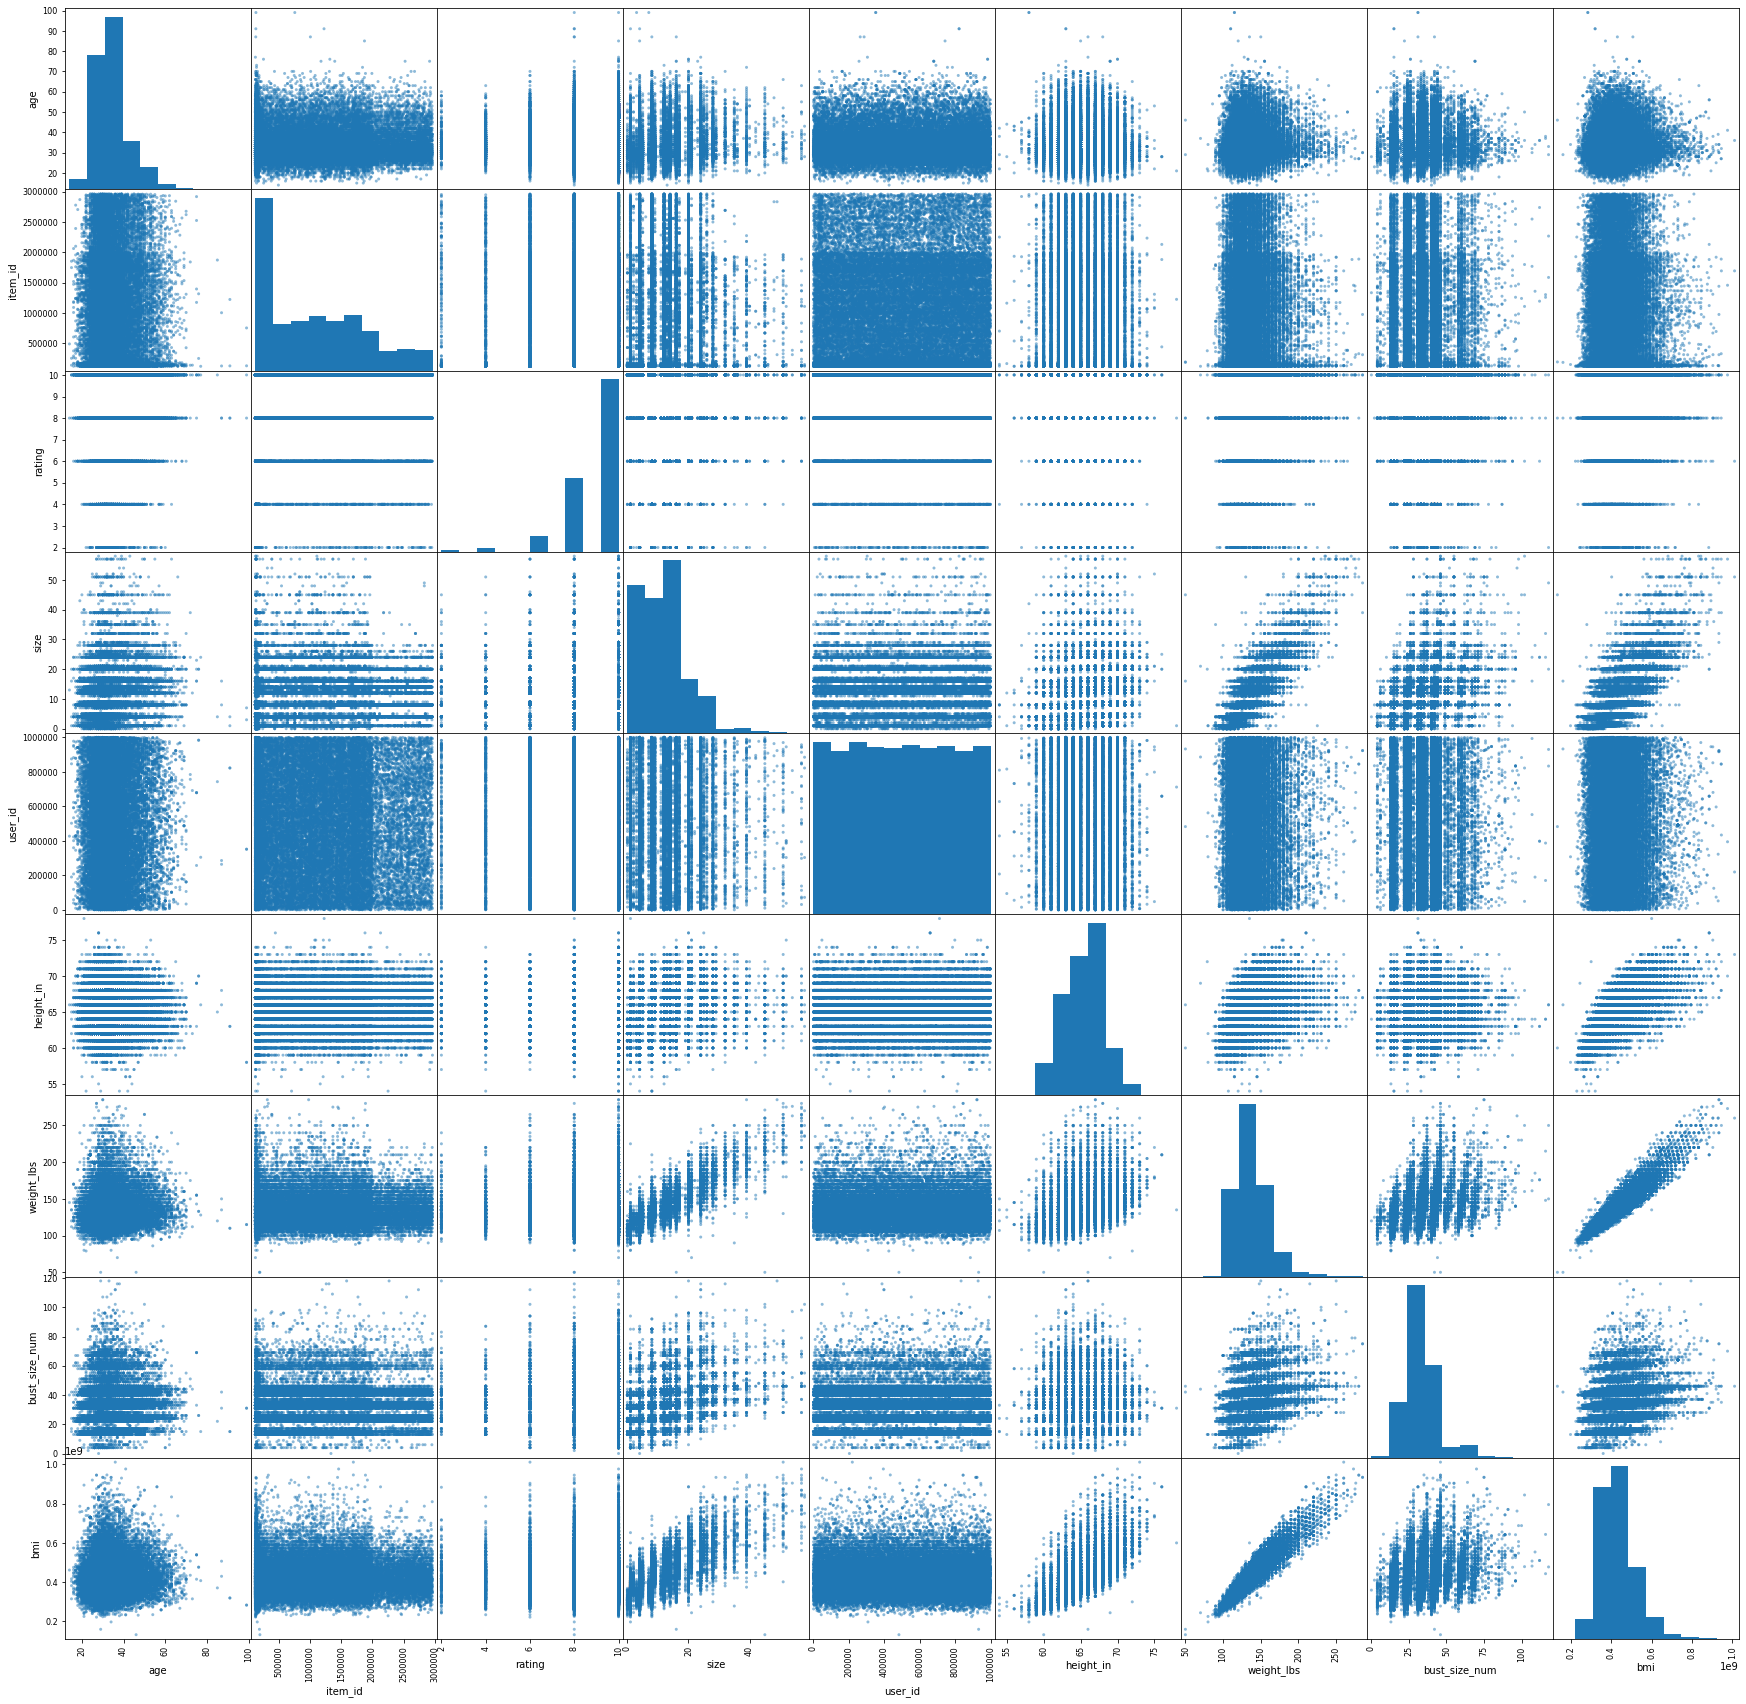

In [19]:
_ = scatter_matrix(df_no_nan, figsize=(30,30))

In [33]:
shuffled = df_no_nan.take(np.random.permutation(len(df_no_nan)))
y = shuffled['rating'].values

In [34]:
ss = StratifiedShuffleSplit(n_splits=5, train_size=0.8)

In [35]:
est = DummyRegressor(strategy='median')
np.mean(cross_val_score(est, shuffled, y, scoring="neg_mean_absolute_error", cv=ss))

-0.9222585924713584

In [36]:
numerics = ['age', 'item_id', 'bust_size_num', 'user_id', 'bmi']
nominal = ['body type', 'category', 'fit', 'rented for']

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerics),
    ("nom", OneHotEncoder(handle_unknown="ignore"), nominal)],
    remainder="drop",
)

pipeline = Pipeline([
    ("pre", preprocessor),
    ("est", LinearRegression()),
])

np.mean(cross_val_score(pipeline, shuffled, y, scoring="neg_mean_absolute_error", cv=ss))

-1.0961426521311108

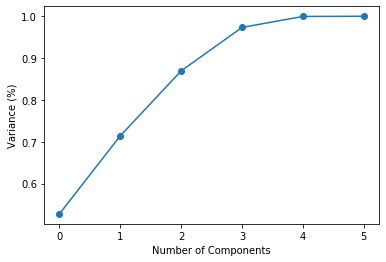

variance with 4 components: 99.948840128145


In [30]:
numerics = ['age', 'size', 'weight_lbs', 'height_in', 'bust_size_num', 'bmi']

pre = ColumnTransformer([("num", StandardScaler(), numerics)], remainder="drop")

# Adapted from https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe

scaled = pre.fit(shuffled).transform(shuffled)
pca = PCA().fit(scaled)

plt.figure()
graph = plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.show()
print(f"variance with 4 components: {(graph[0].get_ydata()[np.where(graph[0].get_xdata()==graph[0].get_xdata()[4])][0])*100}")

In [28]:
numerics = ['age', 'item_id', 'size', 'weight_lbs', 'height_in', 'bust_size_num', 'user_id', 'bmi']
nominal = ['body type', 'category', 'fit', 'rented for']
pca = ['age', 'size', 'weight_lbs', 'height_in', 'bust_size_num', 'bmi']

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerics),
    ("pca", PCA(n_components=5, whiten=True), numerics),
    ("nom", OneHotEncoder(handle_unknown="ignore"), nominal),
], remainder="drop",
)

pipeline = Pipeline([
    ("pre", preprocessor),
    ("est", LinearRegression()),
])

np.mean(cross_val_score(pipeline, shuffled, y, scoring="neg_mean_absolute_error", cv=ss))

-1.0926062690056422

# NLP Review  Summary

In [41]:
nlp_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=50000, min_df=1, max_df=500000, stop_words=stop_words.ENGLISH_STOP_WORDS, analyzer='char', ngram_range=(2, 8))),
    #("est", SGDClassifier(loss='log', penalty='l2', max_iter=500, tol=None, fit_intercept=True, n_jobs=4, l1_ratio=0.9)),
    ("est", LogisticRegression(solver='newton-cg', multi_class='multinomial')), # leans towards false lower numbers more than non multinomial
    #("est", MultinomialNB()),
])

X_train, X_test, y_train, y_test = train_test_split(shuffled['review_summary'], shuffled['rating'], test_size=0.2, stratify=shuffled['rating'])

nlp_pipeline.fit(X_train, y_train)
y_pred = nlp_pipeline.predict(X_test)
print(accuracy_score(y_test, y_pred)*100)
print(confusion_matrix(y_test, y_pred))

summary_predict = nlp_pipeline.predict(shuffled['review_summary'])

X_train, X_test, y_train, y_test = train_test_split(shuffled['review_text'], shuffled['rating'], test_size=0.2, stratify=shuffled['rating'])

nlp_pipeline.fit(X_train, y_train)
y_pred = nlp_pipeline.predict(X_test)
print(accuracy_score(y_test, y_pred)*100)
print(confusion_matrix(y_test, y_pred))

text_predict = nlp_pipeline.predict(shuffled['review_text'])

66.93944353518822
[[   0    1   15    9   14]
 [   0    2   35   35   39]
 [   0    6   89  158  177]
 [   0    0   50  508 1474]
 [   0    2   15  394 4309]]
70.0354609929078
[[   0    1    7   13   18]
 [   0    2   31   45   33]
 [   0    2   67  245  116]
 [   0    0   34  834 1164]
 [   0    0    4  484 4232]]


In [43]:
shuffled['sentiment'] = np.array((summary_predict * text_predict)/10)
(shuffled[['rating', 'sentiment']].describe()).loc[['mean', 'std', 'min', 'max']]

,rating,sentiment
mean,9.077909,9.075552
std,1.442267,1.503847
min,2.000000,0.800000
max,10.000000,10.000000


In [58]:
# using sentiment score only
numerics = ['sentiment']

preprocessor = ColumnTransformer([("num", StandardScaler(), numerics)], remainder="drop")

pipeline = Pipeline([
    ("pre", preprocessor),
    ("est", LinearRegression()),
])

np.mean([cross_val_score(pipeline, shuffled, y, scoring="neg_mean_absolute_error", cv=ss) for x in range(10)])

-0.7249029050719236